In [1]:
library(data.table)
library(dplyr)
library(glmnet)
library(tictoc)
library(tidyverse)
library(ggplot2)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-18


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ readr   1.3.1
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ ggplot2 3.2.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::between()    masks data.table::between()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks data.table::first()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::last()       masks data.

In [3]:
# simulate data for GLM

# let us have 400 cells, and 100 predictors
numCells <- 400
cellNames <- paste0('Cell', 1:numCells)
numPreds <- 100
predNames <- paste0('Pred', 1:numPreds)
numJuncs <- 100
juncNames <- paste0('Junc', 1:numJuncs)

# predictorExp <- matrix(log(rpois(numCells*numPreds, lambda=100)), ncol=numPreds)
predictorExp <- matrix(log(runif(numCells*numPreds, min=0, max=10)+1), ncol=numPreds)
rownames(predictorExp) <- cellNames
colnames(predictorExp) <- predNames

# add Gaussian noise to predictor expression
predictorExp <- predictorExp + matrix(rnorm(numCells*numPreds, mean=0, sd=2), ncol=numPreds)

# construct known parameters as one of 3 possible parameter
# values, with each parameter value treated as normal distribution
# around the mean of that value 
# (i.e. parameters are normally distributed with mean around 
# paramScale, 0, and -paramScale)
paramScale <- 0.15
param1 <- rnorm(numJuncs*numPreds, 0, paramScale)
param2 <- rnorm(numJuncs*numPreds, paramScale, paramScale)
param3 <- rnorm(numJuncs*numPreds, -paramScale, paramScale)
paramW <- sample(1:3, numJuncs*numPreds, replace=TRUE)
param1[paramW != 1] <- 0
param2[paramW != 2] <- 0
param3[paramW != 3] <- 0
knownParam <- param1 + param2 + param3
knownParam <- matrix(knownParam, ncol=numPreds)

juncRates <- knownParam %*% t(predictorExp)
juncRates[juncRates < 0] <- 0
juncExp <- rpois(numCells*numPreds, exp(unlist(juncRates)))
juncExp <- matrix(juncExp, ncol=numCells)
colnames(juncExp) <- cellNames
rownames(juncExp) <- juncNames

In [46]:
# make plotting function for predictions vs. actual counts
compare_predictions_plot <- function(predictions, knownExp, title) {
    predsStacked <- melt(t(predictions))
    dataStacked <- melt(knownExp)
    dataToPlot <- cbind(predsStacked, dataStacked)
    colnames(dataToPlot) <- c('PredJuncName', 'Cell1', 'Prediction', 'JuncName', 'Cell2', 'Count')
    alpha <- 1 / length(unlist(knownExp)) * 2000
    comparisonPlot <- ggplot(dataToPlot, aes(x=log(Count+1), y=log(Prediction+1))) + geom_point(alpha=0.05) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) + ggtitle(title) + theme(plot.title=element_text(size=18), axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"))
    fitCor <- (cor(log(dataToPlot['Prediction'] + 1), log(dataToPlot['Count'] + 1)))
    comparisonPlot <- comparisonPlot + geom_abline(slope=1, intercept=0, linetype=2, size=1.5) + geom_text(x = 5, y = 10, label = (paste0('r = ', round(fitCor, 2))), size=7.5)
    return(comparisonPlot)
}

In [6]:
# general function for GLM training
train_glm <- function(juncExp, trainPredictorExp, testPredictorExp, numExamples=20) {
    trainPreds <- numeric()
    testPreds <- numeric()
    # for (i in c(1:nrow(trainClassInputData))) {
    for (i in c(1:numExamples)) { 
        glmData <- t(rbind(juncExp[i, ], t(trainPredictorExp)))
        colnames(glmData)[1] <- 'junction'
        glmData <- data.frame(glmData)
        regressionFormula <- paste(colnames(glmData)[2:length(colnames(glmData))], collapse='+')
        regressionFormula <- as.formula(paste0("junction ~ ", regressionFormula))
        glmModel <- glm(regressionFormula, family = poisson(), data=glmData)

        # evaluate model against training data
        glmModelTrainPred <- predict(glmModel, newdata=glmData, type='response')
        trainPreds <- cbind(trainPreds, glmModelTrainPred)

        # evaluate model against test data
        glmPredData <- unlist(testPredictorExp)
        glmPredData <- as.data.frame(glmPredData)

        glmModelPred <- predict(glmModel, newdata=glmPredData, type='response')
        testPreds <- cbind(testPreds, glmModelPred)
    }
    return(list(trainPreds=trainPreds, testPreds=testPreds))
}

In [7]:
# general function for GLMNet training
# test GLMnet on mmquant data
train_glmnet <- function(juncExp, trainPredictorExp, testPredictorExp, numExamples=20) {
    trainPreds <- numeric()
    testPreds <- numeric()
    # for (i in c(1:nrow(trainClassInputData))) {
    for (i in c(1:numExamples)) {

        glmPred <- trainPredictorExp
        glmResponse <- unlist(juncExp[i, ])
        glmModel <- glmnet(glmPred, glmResponse, family = 'poisson')

        # evaluate model against training data
        glmModelTrainPred <- predict(glmModel, newx=glmPred, type='response', s=10)
        trainPreds <- cbind(trainPreds, glmModelTrainPred)

        # evaluate model against test data
        glmPredData <- testPredictorExp
        glmModelPred <- predict(glmModel, newx=glmPredData, type='response', s=10)

        testPreds <- cbind(testPreds, glmModelPred)
    }
    return(list(trainPreds=trainPreds, testPreds=testPreds))
}

In [122]:
head(trainJuncExpSparse)
head(trainPredictorExpSparse)

,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,⋯,Cell341,Cell342,Cell343,Cell344,Cell345,Cell346,Cell347,Cell348,Cell349,Cell350
Junc1,2,3,23,0,0,0,1,0,0,0,⋯,0,0,1,3,1,0,2,1,1,1
Junc2,5,1,0,0,4,0,0,0,0,0,⋯,0,0,2,0,0,0,0,1,0,0
Junc3,0,0,1002,2,0,0,1,19,2,0,⋯,1,7,223,0,2,0,1,0,0,0
Junc4,0,0,0,25,0,0,0,0,0,2,⋯,0,1203,0,0,0,0,4,509,1,0
Junc5,4,9,0,63,0,410,18,1,26,1,⋯,246,0,0,0,1722,0,43,0,0,0
Junc6,0,4,1,0,0,3,0,1,2,0,⋯,0,2,0,0,0,0,1,0,0,0


,Pred1,Pred2,Pred3,Pred4,Pred5,Pred6,Pred7,Pred8,Pred9,Pred10,⋯,Pred91,Pred92,Pred93,Pred94,Pred95,Pred96,Pred97,Pred98,Pred99,Pred100
Cell1,1.96813030,2.3015082,2.286303,-1.0728399,0,0.3173691,5.845533,1.6083780,1.051936,4.9974634,⋯,0.000000,1.2854207,0.000000,0.0000000,0.000000,-1.6519365,0.000000,4.6489596,3.5521472,1.546822
Cell2,1.79260432,2.4482885,0.000000,1.2860666,0,3.8410046,0.000000,0.3265859,1.961375,0.0000000,⋯,-1.150744,4.6175030,1.058186,1.1973172,0.000000,0.0000000,0.000000,2.7791334,3.3307269,1.658573
Cell3,0.00000000,-0.7400595,-1.514676,0.7392536,0,3.5714465,4.663513,0.8435411,0.000000,0.0000000,⋯,0.000000,0.0000000,0.000000,0.3852286,3.563388,0.0000000,0.000000,0.0000000,1.0856822,0.000000
Cell4,0.00000000,7.2650464,1.793179,1.5369082,0,0.0000000,1.649631,1.6388085,2.873822,0.7457477,⋯,0.000000,0.0000000,-1.952151,0.5184076,3.711880,4.4837354,0.000000,0.3262526,0.0000000,2.577889
Cell5,3.14342615,0.0000000,-1.477462,0.4774670,0,0.0000000,4.714208,0.0000000,0.000000,-1.1428456,⋯,4.827693,0.0000000,0.000000,3.1244679,0.000000,1.3218414,1.535265,0.0000000,0.9926762,0.000000
Cell6,0.01900404,3.8838173,0.000000,1.4995273,0,0.0000000,0.000000,0.0000000,0.000000,0.0000000,⋯,0.000000,0.2837325,0.000000,0.0000000,0.000000,-0.7781705,0.000000,0.0000000,2.3849868,0.000000


In [8]:
# drop out some observations of the junctions and of the predictors
juncDropoutFrac <- 0.5
juncKeep <- matrix(rbinom(numCells*numPreds, 1, juncDropoutFrac), ncol=numCells)
juncExpSparse <- juncExp
juncExpSparse[juncKeep == 0] <- 0

# each predictor should have a different dropout probability
# first, choose probability of dropout for each predictor using Gaussian
# next, choose probability of dropout for each cell/predictor pair using Bernoulli trial
predictorDropoutFrac <- rnorm(numPreds, mean=0.5, sd=0.25)
predictorDropoutFrac[predictorDropoutFrac < 0] <- 0
predictorDropoutFrac[predictorDropoutFrac > 1] <- 1
predictorKeep <- lapply(predictorDropoutFrac, function(frac) {
    return(rbinom(numCells, 1, frac))
})
predictorKeep <- do.call(cbind, predictorKeep)
predictorExpSparse <- predictorExp
predictorExpSparse[predictorKeep == 0] <- 0

In [9]:
# split data into train and test set
numTrain <- 350
numTest <- nrow(predictorExp) - numTrain

trainPredictorExp <- predictorExp[1:numTrain, ]
testPredictorExp <- predictorExp[(numTrain+1):(numTrain+numTest), ]

trainJuncExp <- juncExp[, 1:numTrain]
testJuncExp <- juncExp[, (numTrain+1):(numTrain+numTest)]

trainPredictorExpSparse <- predictorExpSparse[1:numTrain, ]
testPredictorExpSparse <- predictorExpSparse[(numTrain+1):(numTrain+numTest), ]

trainJuncExpSparse <- juncExpSparse[, 1:numTrain]
testJuncExpSparse <- juncExpSparse[, (numTrain+1):(numTrain+numTest)]

In [106]:
head(predictorKeep)
head(predictorExpSparse)
head(juncKeep)
head(juncExpSparse)

1,1,1,1,0,1,1,1,1,1,⋯,0,1,0,0,0,1,0,1,1,1
1,1,0,1,0,1,0,1,1,0,⋯,1,1,1,1,0,0,0,1,1,1
0,1,1,1,0,1,1,1,0,0,⋯,0,0,0,1,1,0,0,0,1,0
0,1,1,1,0,0,1,1,1,1,⋯,0,0,1,1,1,1,0,1,0,1
1,0,1,1,0,0,1,0,0,1,⋯,1,0,0,1,0,1,1,0,1,0
1,1,0,1,0,0,0,0,0,0,⋯,0,1,0,0,0,1,0,0,1,0


,Pred1,Pred2,Pred3,Pred4,Pred5,Pred6,Pred7,Pred8,Pred9,Pred10,⋯,Pred91,Pred92,Pred93,Pred94,Pred95,Pred96,Pred97,Pred98,Pred99,Pred100
Cell1,1.96813030,2.3015082,2.286303,-1.0728399,0,0.3173691,5.845533,1.6083780,1.051936,4.9974634,⋯,0.000000,1.2854207,0.000000,0.0000000,0.000000,-1.6519365,0.000000,4.6489596,3.5521472,1.546822
Cell2,1.79260432,2.4482885,0.000000,1.2860666,0,3.8410046,0.000000,0.3265859,1.961375,0.0000000,⋯,-1.150744,4.6175030,1.058186,1.1973172,0.000000,0.0000000,0.000000,2.7791334,3.3307269,1.658573
Cell3,0.00000000,-0.7400595,-1.514676,0.7392536,0,3.5714465,4.663513,0.8435411,0.000000,0.0000000,⋯,0.000000,0.0000000,0.000000,0.3852286,3.563388,0.0000000,0.000000,0.0000000,1.0856822,0.000000
Cell4,0.00000000,7.2650464,1.793179,1.5369082,0,0.0000000,1.649631,1.6388085,2.873822,0.7457477,⋯,0.000000,0.0000000,-1.952151,0.5184076,3.711880,4.4837354,0.000000,0.3262526,0.0000000,2.577889
Cell5,3.14342615,0.0000000,-1.477462,0.4774670,0,0.0000000,4.714208,0.0000000,0.000000,-1.1428456,⋯,4.827693,0.0000000,0.000000,3.1244679,0.000000,1.3218414,1.535265,0.0000000,0.9926762,0.000000
Cell6,0.01900404,3.8838173,0.000000,1.4995273,0,0.0000000,0.000000,0.0000000,0.000000,0.0000000,⋯,0.000000,0.2837325,0.000000,0.0000000,0.000000,-0.7781705,0.000000,0.0000000,2.3849868,0.000000


1,1,1,1,0,0,1,0,0,0,⋯,1,1,0,0,1,1,1,0,0,1
1,1,0,0,1,1,1,0,0,0,⋯,0,1,0,0,1,0,0,0,0,0
0,0,1,1,0,0,1,1,1,0,⋯,1,1,0,1,1,1,0,1,0,0
0,0,1,1,1,0,0,1,0,1,⋯,0,0,1,0,1,1,1,1,0,0
1,1,0,1,0,1,1,1,1,1,⋯,1,1,0,1,1,1,0,0,1,0
0,1,1,0,0,1,1,1,1,0,⋯,0,1,1,0,0,0,1,0,1,1


,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,⋯,Cell391,Cell392,Cell393,Cell394,Cell395,Cell396,Cell397,Cell398,Cell399,Cell400
Junc1,2,3,23,0,0,0,1,0,0,0,⋯,0,1,0,0,1,0,1,0,0,2
Junc2,5,1,0,0,4,0,0,0,0,0,⋯,0,2,0,0,5,0,0,0,0,0
Junc3,0,0,1002,2,0,0,1,19,2,0,⋯,18,525,0,4,1,9,0,10,0,0
Junc4,0,0,0,25,0,0,0,0,0,2,⋯,0,0,1441,0,1,56,8,15,0,0
Junc5,4,9,0,63,0,410,18,1,26,1,⋯,314,1,0,285,65,4,0,0,1,0
Junc6,0,4,1,0,0,3,0,1,2,0,⋯,0,7,2,0,0,0,4,0,1,1


In [10]:
# let's see how the GLMs recapitulate the known parameters
# start with normal GLM in R
fullPredOutputGLM <- train_glm(trainJuncExp, trainPredictorExp, testPredictorExp, 20)
sparsePredOutputGLM <- train_glm(trainJuncExpSparse, trainPredictorExpSparse, testPredictorExpSparse, 20)
fullPredOutputGLMNet <- train_glmnet(trainJuncExp, trainPredictorExp, testPredictorExp, 20)
sparsePredOutputGLMNet <- train_glmnet(trainJuncExpSparse, trainPredictorExpSparse, testPredictorExpSparse, 20)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in predict.lm(object, newdata, se.fit,

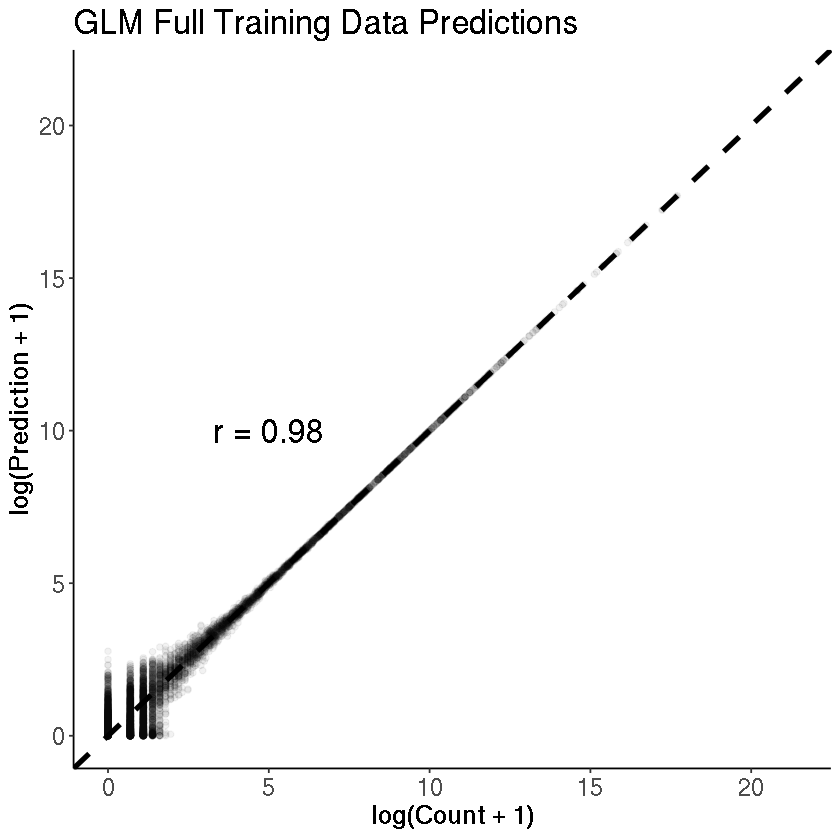

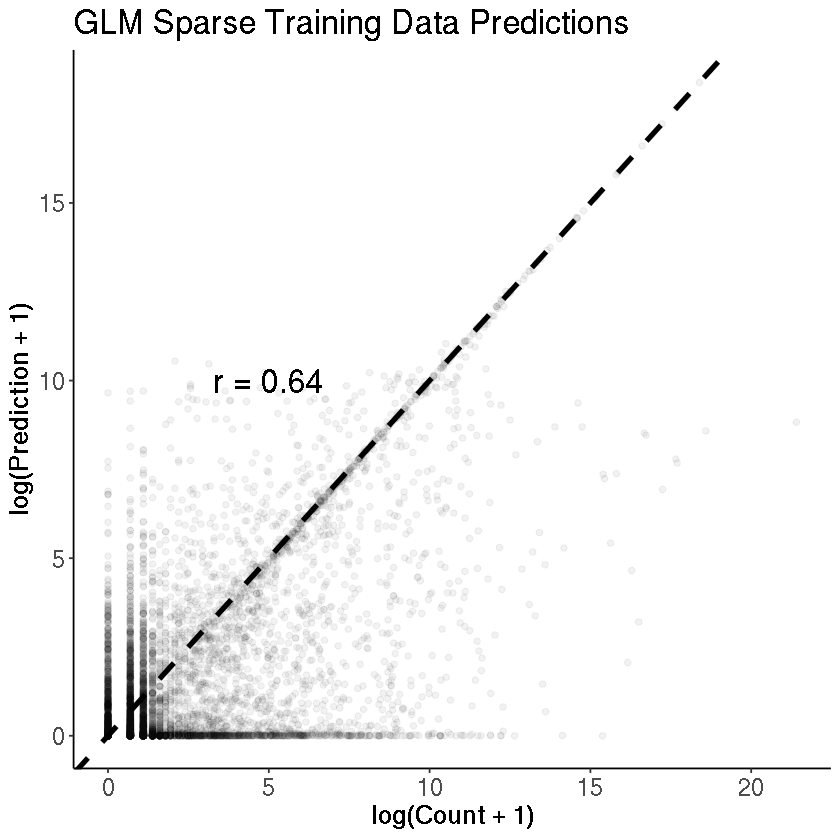

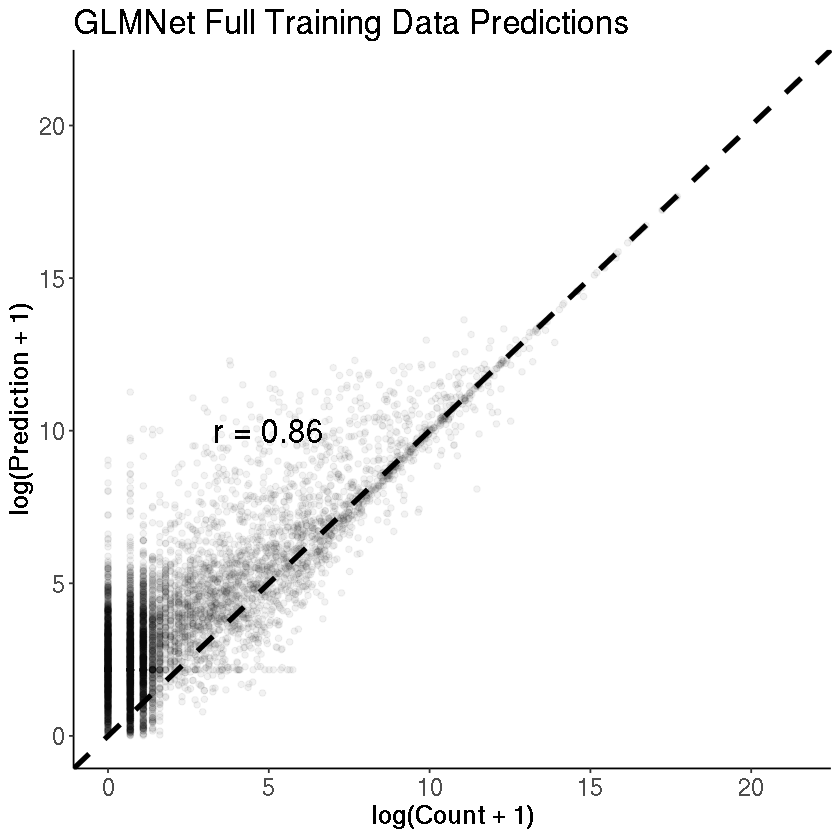

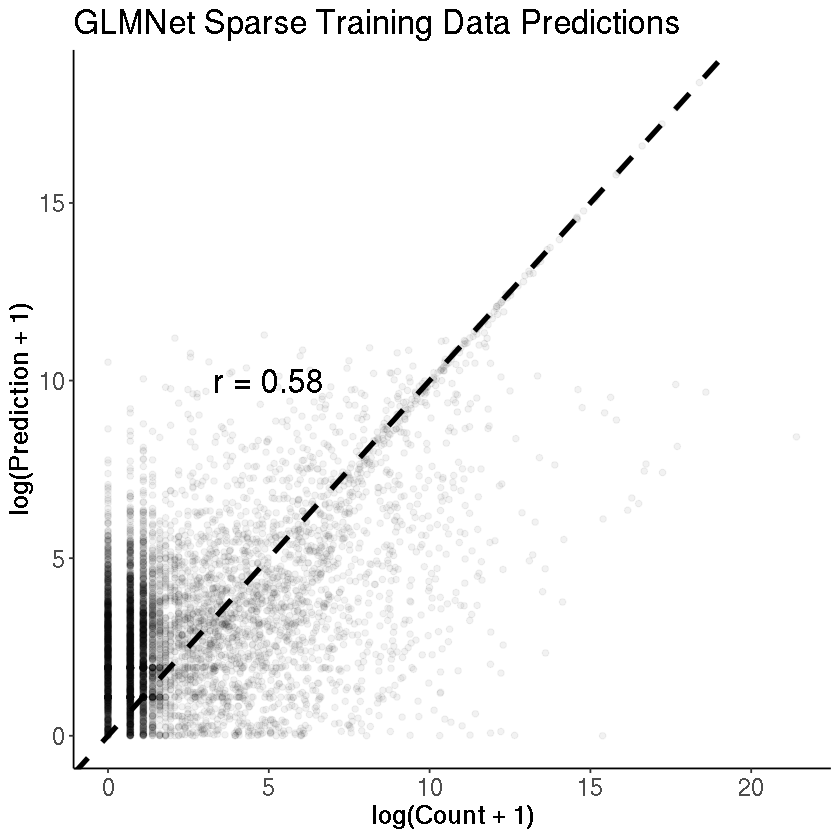

In [47]:
# plot predictions to actual counts for training data
compare_predictions_plot(fullPredOutputGLM[['trainPreds']], trainJuncExp[1:20, ], 'GLM Full Training Data Predictions')
compare_predictions_plot(sparsePredOutputGLM[['trainPreds']], trainJuncExp[1:20, ], 'GLM Sparse Training Data Predictions')
compare_predictions_plot(fullPredOutputGLMNet[['trainPreds']], trainJuncExp[1:20, ], 'GLMNet Full Training Data Predictions')
compare_predictions_plot(sparsePredOutputGLMNet[['trainPreds']], trainJuncExp[1:20, ], 'GLMNet Sparse Training Data Predictions')

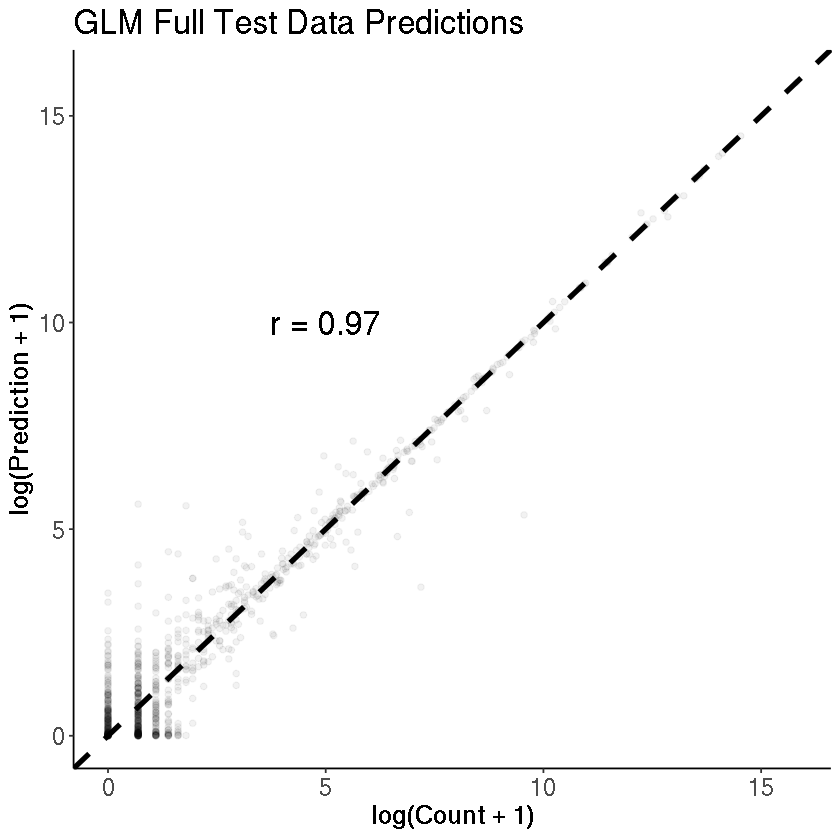

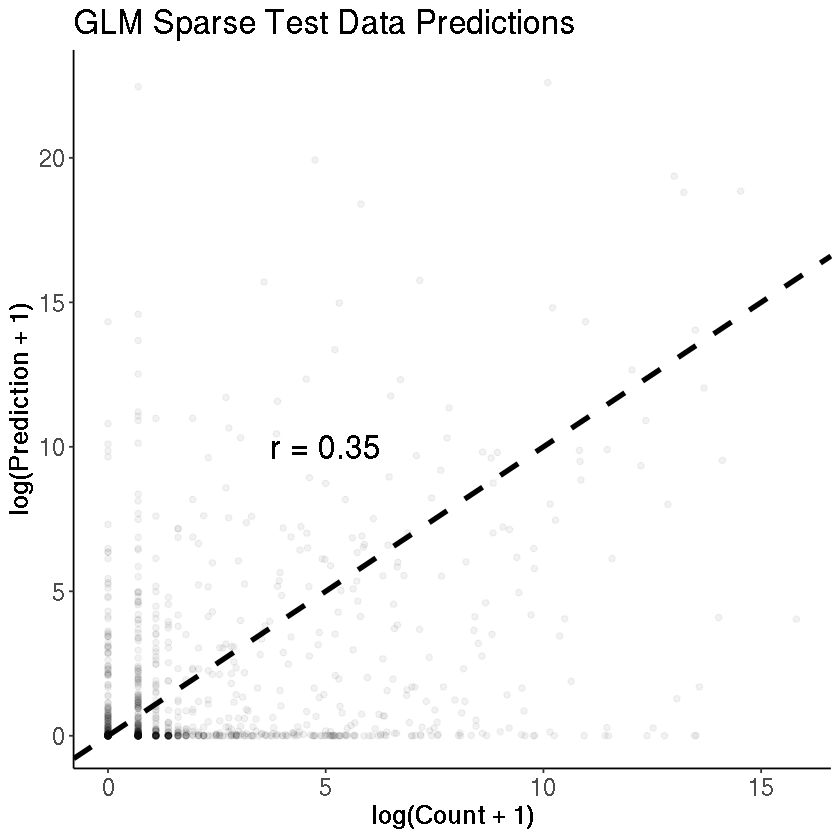

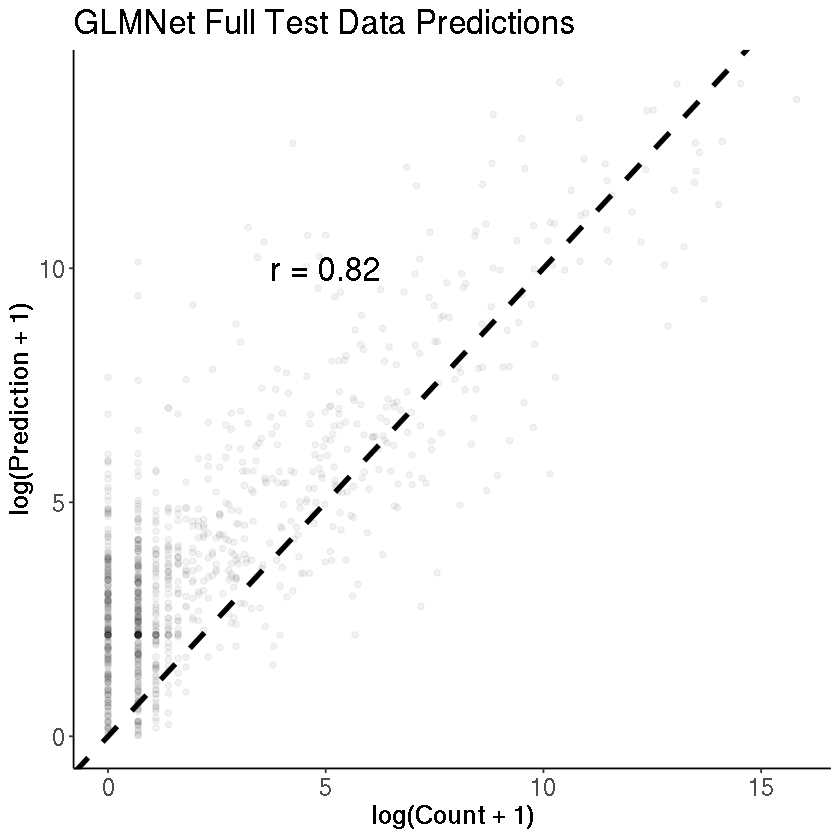

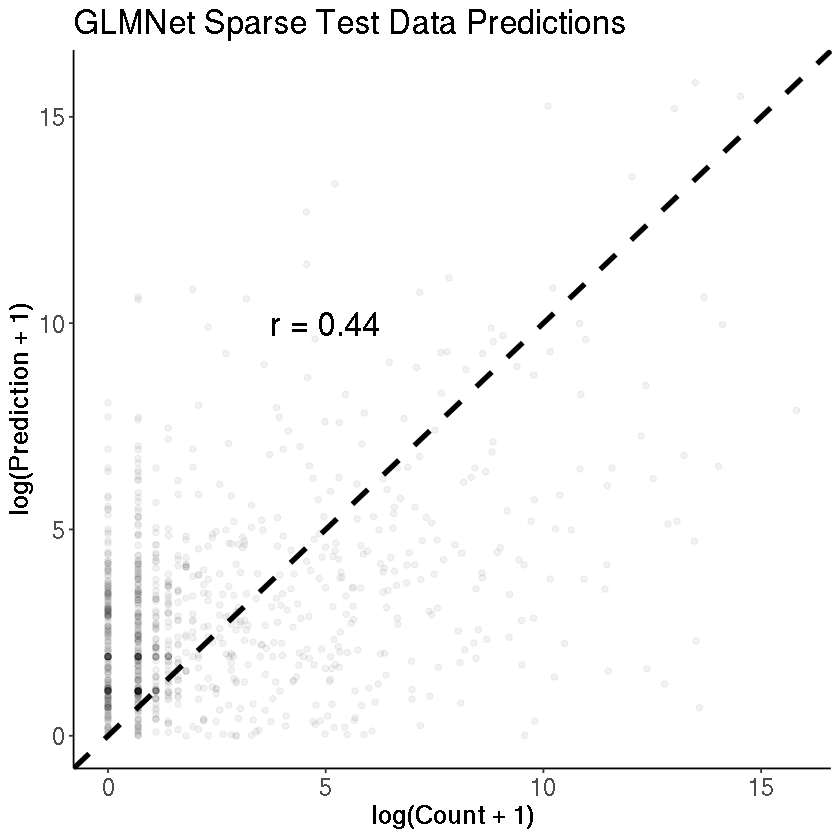

In [48]:
# plot predictions to actual counts for testing data
compare_predictions_plot(fullPredOutputGLM[['testPreds']], testJuncExp[1:20, ], 'GLM Full Test Data Predictions')
compare_predictions_plot(sparsePredOutputGLM[['testPreds']], testJuncExp[1:20, ], 'GLM Sparse Test Data Predictions')
compare_predictions_plot(fullPredOutputGLMNet[['testPreds']], testJuncExp[1:20, ], 'GLMNet Full Test Data Predictions')
compare_predictions_plot(sparsePredOutputGLMNet[['testPreds']], testJuncExp[1:20, ], 'GLMNet Sparse Test Data Predictions')